# 自定义 relay 算子(python)

In [2]:
from testing import viz_expr # 可视化 relay

In [2]:
from tvm.relay.testing import run_infer_type
from tvm.relay.dataflow_pattern import (
    wildcard, is_op,
    # FunctionPattern,
    DFPatternCallback,
    rewrite
)
import tvm
from tvm.ir.attrs import DictAttrs
from tvm import relay, te, topi
from tvm.relay.op import op as _op
from tvm.target import generic_func

@generic_func
def schedule_special_op(attrs, outs, target):
    with target:
        outs = [outs] if isinstance(outs, te.tensor.Tensor) else outs
        output = outs[0]
        sch = te.create_schedule(output.op)   
        return sch

```{topic} 主题
尽可能仅仅使用 Python 实现 Relay 算子的定义。
```

## 构建 `reshape4d_softmax_reshape2d` ONNX 算子

In [3]:
from d2py.utils.file import mkdir
root_dir = ".temp"
mkdir(f"{root_dir}/logs")

In [4]:
import torch
from torch.nn import functional as F
from torch import nn
from torch.onnx import OperatorExportTypes, utils

class M(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 8, 1, 1, 0, bias=False, groups=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        b, c, h, w = x.shape
        x = x.view((b, h, w, c))
        x = F.softmax(x, dim=3)
        x = x.view((b, h * w * c))
        return x

model = M()
model.eval()

shape = 1, 3, 8, 8
input_name = "data"
xx = torch.rand(*shape, dtype=torch.float32, requires_grad=False)
# model = torch.jit.trace(model, xx)
# 导出模型
output_name = "test"
utils.export(
    model,               # torch 模型
    xx,                         # 模型输入或者对于多个输入，使用元组
    f"{root_dir}/{output_name}.onnx",               # 模型保存的位置（可以是文件或类似文件的对象）
    export_params=True,        # 将训练后的参数权重存储在模型文件内
    opset_version=17,          # 导出模型的 ONNX 版本
    do_constant_folding=True,  # 是否执行常量折叠以进行优化
    input_names = [input_name],    # 模型的输入名称
    output_names = ['output'], # 模型的输出名称
    keep_initializers_as_inputs=True,
    # export_modules_as_functions=True,
    verbose=True,
    operator_export_type=OperatorExportTypes.ONNX_FALLTHROUGH,
    # dynamic_axes={'data' : {0 : 'batch_size'},    # 可变长度的轴
    #               'output' : {0 : 'batch_size'}}
)

Exported graph: graph(%data : Float(1, 3, 8, 8, strides=[192, 64, 8, 1], requires_grad=0, device=cpu),
      %conv.weight : Float(8, 3, 1, 1, strides=[3, 1, 1, 1], requires_grad=1, device=cpu)):
  %/conv/Conv_output_0 : Float(1, 8, 8, 8, strides=[512, 64, 8, 1], requires_grad=0, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1], onnx_name="/conv/Conv"](%data, %conv.weight), scope: __main__.M::/torch.nn.modules.conv.Conv2d::conv # /media/pc/data/tmp/cache/conda/envs/py312x/lib/python3.12/site-packages/torch/nn/modules/conv.py:456:0
  %/pool/GlobalAveragePool_output_0 : Float(1, 8, 1, 1, strides=[8, 1, 1, 1], requires_grad=1, device=cpu) = onnx::GlobalAveragePool[onnx_name="/pool/GlobalAveragePool"](%/conv/Conv_output_0), scope: __main__.M::/torch.nn.modules.pooling.AdaptiveAvgPool2d::pool # /media/pc/data/tmp/cache/conda/envs/py312x/lib/python3.12/site-packages/torch/nn/functional.py:1260:0
  %/Constant_output_0 : Long(4, strides=

前端导入：

In [5]:
import numpy as np
import onnx
import tvm
from tvm import relay
onnx_model = onnx.load(f"{root_dir}/{output_name}.onnx")
mod, params = relay.frontend.from_onnx(onnx_model, {input_name: shape}, freeze_params=True)
mod = relay.transform.InferType()(mod)
mod.show()

## 变换 `reshape4d_softmax_reshape2d` 为 `softmax_transpose_reshape2d`

其实 `reshape4d_softmax_reshape2d` 等价于如下结构：

In [6]:
class Reshape4dSoftmaxReshape2dRewrite(DFPatternCallback):
    def __init__(self):
        super().__init__()
        self.x = wildcard()
        self.reshape4d = is_op("reshape")(self.x) # 将 NCHW 转换为 NHWC，其他 H=W=1
        self.softmax = is_op("nn.softmax")(self.reshape4d)
        self.softmax_axis = self.softmax.has_attr({"axis": 3})
        self.reshape2d = is_op("reshape")(self.softmax_axis)
        self.pattern = self.reshape2d

    def callback(self, pre, post, node_map):
        x = node_map[self.x][0]
        relay.transform.InferTypeLocal(x).shape
        x = relay.nn.softmax(x, axis=1)
        relay.transform.InferTypeLocal(x)
        x = relay.transpose(x, (0, 2, 3, 1))
        relay.transform.InferTypeLocal(x)
        x = relay.reshape(x, (1, -1))
        relay.transform.InferTypeLocal(x)
        return x

In [7]:
mod["main"] = rewrite(Reshape4dSoftmaxReshape2dRewrite(), mod["main"])
mod.show()

## 声明 `softmax_transpose_reshape2d` 算子类型关系

In [8]:
def custom_softmax_transpose_reshape2d_rel(arg_types, attrs):
    assert len(arg_types) == 1, "type relation arg number mismatch!"
    if attrs:
        assert isinstance(attrs, DictAttrs)
    inputa_type = arg_types[0]
    shape = inputa_type.shape
    shape = shape[0], shape[1] * shape[2] * shape[3]
    return relay.TensorType(shape, inputa_type.dtype)

## 注册 `softmax_transpose_reshape2d` 算子

In [9]:
op_name = "softmax_transpose_reshape2d"
_op.register(op_name, r"code(cal softmax_transpose_reshape2d.)code")
_op.get(op_name).set_num_inputs(1)
_op.get(op_name).add_argument("data", "Tensor", "The input data tensor.")
_op.get(op_name).set_attrs_type_key("DictAttrs")
_op.get(op_name).add_type_rel(op_name, custom_softmax_transpose_reshape2d_rel)
_op.get(op_name).set_support_level(1)
_op.register_pattern(op_name, _op.OpPattern.COMM_REDUCE)
_op.register_stateful(op_name, False) # 无状态算子

In [10]:
_op.register_stateful??

Signature: _op.register_stateful(op_name, stateful, level=10)
Source:   
def register_stateful(op_name, stateful, level=10):
    """Register stateful flag for an op.

    Parameters
    ----------
    op_name : str
        The name of the op.

    stateful : bool
        The stateful flag.

    level : int
        The priority level
    """
    tvm.ir.register_op_attr(op_name, "TOpIsStateful", stateful, level)
File:      /media/pc/data/lxw/ai/tvm/python/tvm/relay/op/op.py
Type:      function

```{note}
`IsStateful` 的函数，用于判断算子是否是有状态的或包含内部状态。

目前 TVM 注册的所有 primitive ops 都是纯粹的，这个属性是为了将来可能的兼容性原因而保留的。如果需要处理有状态的算子，可以通过添加额外的句柄参数来解决这个问题。
```

## 测试 `softmax_transpose_reshape2d` 算子类型推断

In [11]:
def softmax_transpose_reshape2d(x):
    return relay.Call(_op.get(op_name), [x])

In [12]:
tp = relay.TensorType((1, 2, 1, 1), "float32")
x = relay.var("x", tp)
sb = relay.ScopeBuilder()
t1 = sb.let("t1", softmax_transpose_reshape2d(x))
t2 = sb.let("t2", relay.add(t1, relay.const(1, dtype="float32")))
sb.ret(t2)
f = relay.Function([x], sb.get())

In [13]:
print(tvm.IRModule.from_expr(f))

def @main(%x: Tensor[(1, 2, 1, 1), float32]) {
  let %t1 = softmax_transpose_reshape2d(%x);
  let %t2 = add(%t1, 1f);
  %t2
}



In [14]:
f_type = relay.transform.InferTypeLocal(f)
f_type

I.FuncType([], [I.TensorType([1, 2, 1, 1], "float32")], I.TensorType([1, 2], "float32"))

In [15]:
print(relay.transform.InferType()(tvm.IRModule.from_expr(f)))

def @main(%x: Tensor[(1, 2, 1, 1), float32] /* ty=Tensor[(1, 2, 1, 1), float32] */) -> Tensor[(1, 2), float32] {
  let %t1: Tensor[(1, 2), float32] /* ty=Tensor[(1, 2), float32] */ = softmax_transpose_reshape2d(%x) /* ty=Tensor[(1, 2), float32] */;
  let %t2: Tensor[(1, 2), float32] /* ty=Tensor[(1, 2), float32] */ = add(%t1, 1f /* ty=float32 */) /* ty=Tensor[(1, 2), float32] */;
  %t2
}



## 融合 mod 部分算子为 ``softmax_transpose_reshape2d``

可视化表达式：

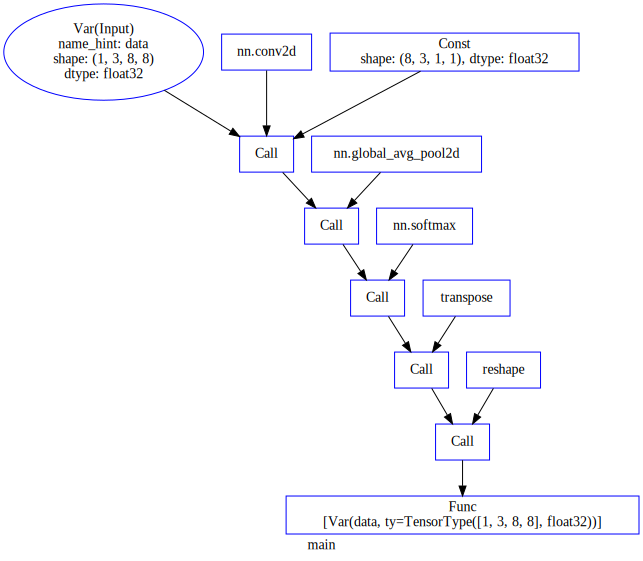

In [16]:
viz_expr(mod["main"])

In [17]:
class SoftmaxTransposeReshape2dFuse(DFPatternCallback):
    def __init__(self):
        super().__init__()
        self.x = wildcard()
        self.softmax = is_op("nn.softmax")(self.x)
        self.softmax_axis = self.softmax.has_attr({"axis": 1})
        # 将 NCHW 转换为 NHWC
        self.transpose = is_op("transpose")(self.softmax_axis).has_attr({"axes": (0, 2, 3, 1)})
        self.reshape2d = is_op("reshape")(self.transpose).has_attr({"newshape": (1, -1)})
        self.pattern = self.reshape2d

    def callback(self, pre, post, node_map):
        x = node_map[self.x][0]
        relay.transform.InferTypeLocal(x).shape
        return softmax_transpose_reshape2d(x)

In [18]:
mod.show()

In [19]:
expr = mod["main"]
expr = rewrite(SoftmaxTransposeReshape2dFuse(), expr)
run_mod = tvm.IRModule.from_expr(expr)
run_mod = relay.transform.InferType()(run_mod)
run_mod.show()

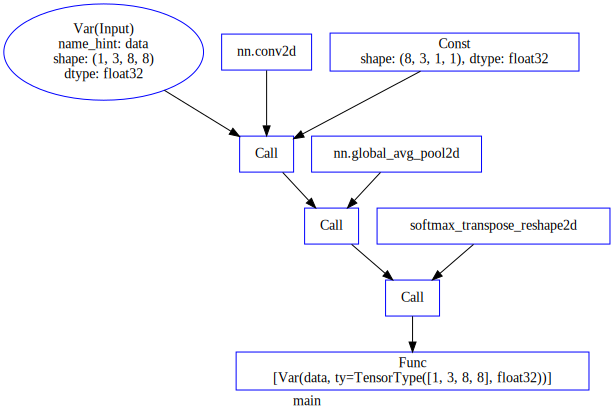

In [20]:
viz_expr(run_mod["main"])

## 定义 ``softmax_transpose_reshape2d`` 计算与调度

In [21]:
def topi_softmax_transpose_reshape2d(x):
    """reshape4d_softmax_reshape2d TOPI 计算"""
    n, c, h, w = x.shape
    x = topi.nn.softmax(x, axis=1)
    x = topi.reshape(x, (n, h * w * c))
    return x

In [22]:
@_op.register_compute(op_name)
def output_softmax_transpose_reshape2d_compute(attrs, inputs, out_type):
    """reshape4d_softmax_reshape2d Relay 计算"""
    assert len(inputs) == 1, "输入参数数量不为 1"
    x = topi_softmax_transpose_reshape2d(inputs[0])
    return [x]

In [23]:
_op.register_schedule(op_name, schedule_special_op) # 定义调度

GenericFunc(0x92187f0)

## 验证 ``softmax_transpose_reshape2d`` 数值一致性

In [24]:
data = np.random.normal(0, 1, size=shape).astype("float32")
torch_out = model(torch.from_numpy(data)).detach().numpy()


target = 'llvm'
dev = tvm.device(target, 0)


# 原始模型
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target, params=params)
func = lib[lib.libmod_name]
module = tvm.contrib.graph_executor.GraphModule(func(dev))
module.run(**{input_name: data})
output1 = module.get_output(0).numpy()

# 重写后的模型
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(run_mod, target, params=params)
func = lib[lib.libmod_name]
module = tvm.contrib.graph_executor.GraphModule(func(dev))
module.run(**{input_name: data})
output2 = module.get_output(0).numpy()

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


In [25]:
torch_out

array([[0.13445556, 0.12515777, 0.11348397, 0.12063695, 0.13582838,
        0.12997034, 0.11783069, 0.12263636]], dtype=float32)

In [26]:
output1

array([[0.13445556, 0.12515777, 0.11348397, 0.12063695, 0.13582838,
        0.12997034, 0.1178307 , 0.12263636]], dtype=float32)

In [27]:
output2

array([[0.13445556, 0.12515777, 0.11348397, 0.12063695, 0.13582838,
        0.12997034, 0.1178307 , 0.12263636]], dtype=float32)

## 打印带有 ``softmax_transpose_reshape2d`` 算子的量化问题

In [28]:
with tvm.transform.PassContext(opt_level=3):
    with relay.quantize.qconfig(
        skip_conv_layers=[],
        # calibrate_mode="kl_divergence", 
        weight_scale="max",
        # round_for_shift=True,
        # rounding="TONEAREST", # "UPWARD" or "TONEAREST"
        skip_dense_layer=False,
    ):
        qmod = relay.quantize.quantize(run_mod, params)
qmod.show()